In [1]:
# Importation des modules

import pandas as pd
from gensim.models import Word2Vec
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

#Affichage de toutes les colonnes

pd.set_option('display.max_columns', 500)

In [57]:
def moyenne(L):
    s = 0
    for i in L:
        if str(i) == 'inf':
            pass
        else:
            s += i
        
    return s/len(L)

In [2]:
w2v_model_novice = Word2Vec.load("results/word2vec_novice_300.model")

w2v_model_exp = Word2Vec.load("results/word2vec_exp_300.model")

In [3]:
words_novice = list(w2v_model_novice.wv.vocab.keys())
words_exp = list(w2v_model_exp.wv.vocab.keys())

### Overlap et spread

In [4]:
def overlap(model1, model2, n , word):

    neighborhood_1 = set([i[0] for i in model1.wv.most_similar(positive=[word], topn = n)])
    neighborhood_2 = set([i[0] for i in model2.wv.most_similar(positive=[word], topn = n)])

    return len(neighborhood_1.intersection(neighborhood_2))

In [5]:
words_common = list(set(words_exp).intersection(set(words_novice)))
random.shuffle(words_common)

/Users/lilian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lilian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


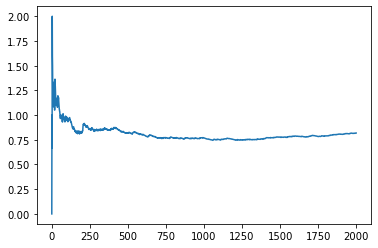

In [6]:
L_10 = [overlap(w2v_model_novice, w2v_model_exp, 10, word) for word in words_common[:2000]]
plt.plot([np.mean(L_10[:i]) for i in range(2000)])

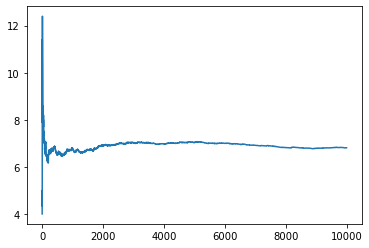

In [7]:
L_100 = [overlap(w2v_model_novice, w2v_model_exp, 100, word) for word in words_common[:10000]]
plt.plot([np.mean(L_100[:i]) for i in range(10000)])

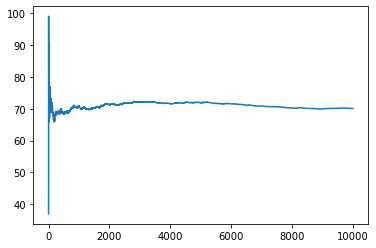

In [8]:
L_1000 = [overlap(w2v_model_novice, w2v_model_exp, 1000, word) for word in words_common[:10000]]
plt.plot([np.mean(L_1000[:i]) for i in range(10000)])

In [9]:
def rank(model, i, j):
    
    k = -1
    K = 10
    
    while k == -1 and 10 * K < len(words_exp):
        neighborhood = [i[0] for i in model.wv.most_similar(positive=[i], topn = K)]
        try:
            k = neighborhood.index(j)
        except:
            k = -1
        K *= 10
            
    return k + 1

def spread(model1, model2, n, word):

    neighborhood_1 = [i[0] for i in model1.wv.most_similar(positive=[word], topn = n)]
    ranks = [rank(model2, word, j) for j in neighborhood_1]
    return max(ranks)

In [10]:
#print(w2v_model_exp.wv.most_similar(positive=['droite'], topn = 10))
#rank(w2v_model_exp, 'droite', 'sarkozysme')

In [11]:
spread(w2v_model_novice, w2v_model_exp, 10, 'droite')

831

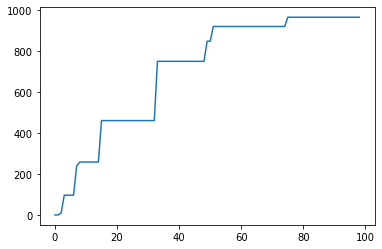

In [12]:
plt.plot([spread(w2v_model_novice, w2v_model_exp, i, 'demain') for i in range(1,100)])

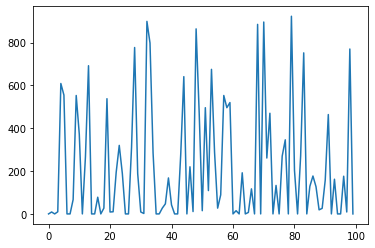

In [13]:
plt.plot([spread(w2v_model_novice, w2v_model_exp, 6, word) for word in words_common[:100]])

## WMD 

In [14]:
# Normalisation des vecteurs

w2v_model_exp.init_sims(replace = True)
w2v_model_novice.init_sims(replace = True)

In [15]:
df0 = pd.read_csv('data/data_cleaned_NLP.csv', sep = ',', encoding = 'latin-1')

In [16]:
df1 = df0[['Réplique', 'Groupe', 'tokenized_replique', 'Orateur']].copy()

df_novice = df1[df1['Groupe'] == 'Novice'].copy()
df_exp = df1[df1['Groupe'] == 'Exp'].copy()

In [17]:
df_novice = df_novice.dropna()

df_exp = df_exp.dropna()

In [18]:
phrase0 = df_novice.iloc[0]['tokenized_replique'].split(' ')
phrase1 = df_novice.iloc[1]['tokenized_replique'].split(' ')
phrase2 = df_novice.iloc[2]['tokenized_replique'].split(' ')

### Calcul des distances intra

#### Novices

In [19]:
df_novice_shuffled = df_novice.sample(frac=1)
phrases_novice = [df_novice_shuffled.iloc[i]['tokenized_replique'].split(' ') for i in range(2 * 2000)]

In [20]:
WMD_novices = [w2v_model_novice.wmdistance(phrases_novice[i], phrases_novice[i + 1]) for i in range(0, 4000, 2)]

<ipython-input-20-fd016fc35ff4>:1: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  WMD_novices = [w2v_model_novice.wmdistance(phrases_novice[i], phrases_novice[i + 1]) for i in range(0, 4000, 2)]


In [58]:
means_novice = [moyenne(WMD_novices[:i]) for i in range(1, 2000)]

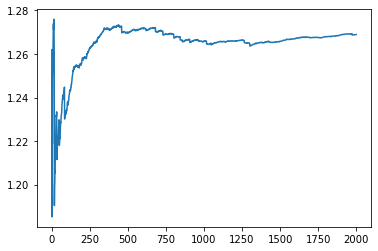

In [60]:
plt.plot([i for i in range(1, 2000)], means_novice)

In [61]:
distance_intra_novice = np.mean(means_novice[300:500])
print(distance_intra_novice)

1.2709758766813128


#### Non-novices

In [62]:
df_exp_shuffled = df_exp.sample(frac = 1)
phrases_exp = [df_exp_shuffled.iloc[i]['tokenized_replique'].split(' ') for i in range(2 * 2000)]

In [25]:
WMD_exp = [w2v_model_exp.wmdistance(phrases_exp[i], phrases_exp[i + 1]) for i in range(0, 4000, 2)]

<ipython-input-25-8ca24bd417e6>:1: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  WMD_exp = [w2v_model_exp.wmdistance(phrases_exp[i], phrases_exp[i + 1]) for i in range(0, 4000, 2)]


In [64]:
means_exp = [moyenne(WMD_exp[:i]) for i in range(1, 2000)]

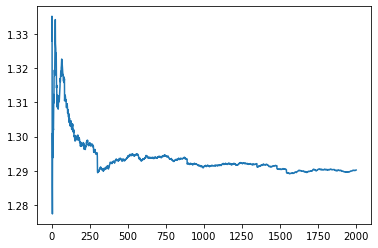

In [65]:
plt.plot([i for i in range(1, 2000)], means_exp)

In [66]:
distance_intra_exp = np.mean(means_exp[300:500])
print(distance_intra_exp)

1.2920924676833037


### Distances inter

In [67]:
WMD_inter_model_exp = [w2v_model_exp.wmdistance(phrases_exp[i], phrases_novice[i]) for i in range(0, 600)]
WMD_inter_model_novice = [w2v_model_novice.wmdistance(phrases_exp[i], phrases_novice[i]) for i in range(0, 600)]

<ipython-input-67-3c7cafd3992f>:1: DeprecationWarning:

Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).

<ipython-input-67-3c7cafd3992f>:2: DeprecationWarning:

Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).



In [68]:
means_model_exp = [np.mean(WMD_inter_model_exp[:i]) for i in range(1, 600)]
means_model_novice = [moyenne(WMD_inter_model_novice[:i]) for i in range(1, 600)]

In [69]:
moyenne(WMD_inter_model_novice[:400])

1.2690398240434346

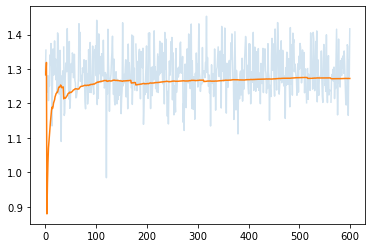

In [70]:
plt.plot([i for i in range(600)], WMD_inter_model_novice, alpha = .2)
plt.plot([i for i in range(1, 600)], means_model_novice)

In [71]:
distance_inter_novice = np.mean(means_model_novice[300:600])
print(distance_inter_novice)

1.2705884396828768


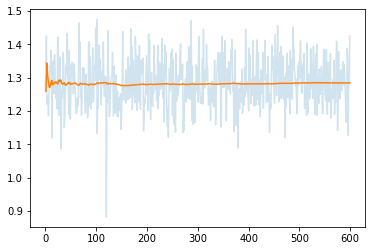

In [72]:
plt.plot([i for i in range(600)], WMD_inter_model_exp, alpha = .2)
plt.plot([i for i in range(1, 600)], means_model_exp)

In [73]:
distance_inter_exp = np.mean(means_model_exp[300:500])
print(distance_inter_exp)

1.2814946741269733


### Etude des scores

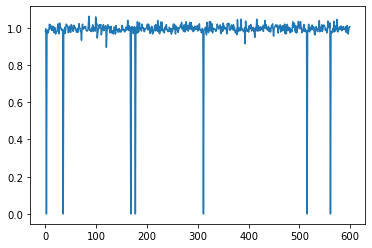

In [74]:
# Rapport des distances selon le modèle

plt.plot([WMD_inter_model_exp[i]/WMD_inter_model_novice[i] for i in range(600)])

In [38]:
[WMD_inter_model_exp[i]/WMD_inter_model_novice[i] for i in range(600)].index(0)

35

In [75]:
print(WMD_inter_model_novice[35],phrases_exp[35], df_exp_shuffled.iloc[35]['Réplique'])


inf ['très', 'bien']  Très bien<U+0080>!


In [76]:
[WMD_inter_model_exp[i]/WMD_inter_model_novice[i] for i in range(250, 400)].index(0)

61

In [77]:
print(WMD_inter_model_novice[311],phrases_exp[311], df_exp_shuffled.iloc[311]['Réplique'])


inf ['allô', 'allô']  Allô  Allô<U+0080>! (Sourires sur les bancs du groupe LR.)


### Résumé WMD

In [78]:
scores = [distance_intra_exp, distance_intra_novice, distance_inter_exp, distance_inter_novice]

In [79]:
px.histogram(x = ['Intra non-novice', 'Intra novice', 'Inter avec modèle non-novice', 'Inter avec modèle novice'], 
             y = scores,
             range_y = [0.995 * min(scores), 1.005 * max(scores)])